<a href="https://colab.research.google.com/github/sailkargutkar/Python-Projects/blob/HELBNTODR100369/HELBNTODR100369.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scattertext

     |████████████████████████████████| 7.2MB 7.8MB/s 


In [ ]:
!pip install "git+https://github.com/facebookresearch/fastText.git"

  Cloning https://github.com/facebookresearch/fastText.git to /tmp/pip-req-build-oj7at3o2
  Running command git clone -q https://github.com/facebookresearch/fastText.git /tmp/pip-req-build-oj7at3o2
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3012536 sha256=6b22444a88b53529a0893189bba3911db728750ea8d5c30bef5b22b47445bc79
  Stored in directory: /tmp/pip-ephem-wheel-cache-lwzslowf/wheels/69/f8/19/7f0ab407c078795bc9f86e1f6381349254f86fd7d229902355
Successfully built fasttext


Install all necessary packages

In [ ]:
import fasttext.util
import numpy as np
import pandas as pd
import re
import scattertext as st
import spacy
import nltk

from keras import layers
from keras.layers import Dropout 
from keras.models import Sequential
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from sklearn.model_selection import train_test_split


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Read in data and look at first item

In [ ]:
df = pd.read_csv('/content/agr_en_train.csv', names=['unique_id','text','aggression-level'], sep=',')
print(df.iloc[0])

unique_id                                 facebook_corpus_msr_1723796
text                Well said sonu..you have courage to stand agai...
aggression-level                                                  OAG
Name: 0, dtype: object


Check for missing values

In [ ]:
df.isna().values.any()

False

Count the occurrences per Aggression Level

In [ ]:
df['aggression-level'].value_counts() 

Data pre-processing

In [ ]:
# Convert to lover case
df['text'] = df['text'].str.lower() 

# Remove all numbers from Text column
df['text'] = df['text'].str.replace('\d+', '')

# Remove any type of alphanumeric character from our dataset.
df.text.str.replace('[^a-zA-Z0-9]', '')

# Remove any commas, dollar symbol, double quotes, single quotes, question mark and single letter from our dataset.

# Remove multiple space fromour dataset.
df['text'] = df['text'].replace('\s+', ' ', regex=True)
df['text'] = df['text'].str.replace(',', '')
df['text'] = df['text'].str.replace('$', '')
df['text'] = df['text'].str.replace('"', '')
df['text'] = df['text'].str.replace('?', '')
df['text'] = df['text'].str.replace("'", "")
df['text'] = df['text'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
df['text'] = df['text'].str.replace("/", "")
df['text'] = df['text'].str.replace("*", "")
df['text'] = df['text'].str.replace("+", "")
df['text'] = df['text'].str.replace(":", "")
df['text'] = df['text'].str.replace("(", "")
df['text'] = df['text'].str.replace(")", "")
df['text'] = df['text'].str.replace("[", "")
df['text'] = df['text'].str.replace("]", "")

# Remove punctuation from our detaset.
df['text'] = df['text'].str.replace('[^\w\s]','')

Identify the top occurring words per Aggression Level

In [ ]:
nlp = spacy.load('en')
df['parsed'] = df.text.apply(nlp)
data = st.CorpusFromParsedDocuments(df, category_col='aggression-level', 
                                      parsed_col='parsed').build().remove_terms(nlp.Defaults.stop_words, ignore_absences=True)

freq_df = data.get_term_freq_df()
oag_tw = freq_df.sort_values(by=['OAG freq'], ascending=False)
oag_tw = oag_tw.drop(oag_tw.columns[[1,2]], axis=1)
nag_tw = freq_df.sort_values(by=['NAG freq'], ascending=False)
nag_tw = nag_tw.drop(nag_tw.columns[[0,2]], axis=1)
cag_tw = freq_df.sort_values(by=['CAG freq'], ascending=False)
cag_tw = cag_tw.drop(cag_tw.columns[[0,1]], axis=1)

print(oag_tw.head())
print(nag_tw.head())
print(cag_tw.head())

        OAG freq
term            
u            420
india        396
people       372
like         317
indian       279
        NAG freq
term            
india        616
people       357
good         355
indian       350
like         315
        CAG freq
term            
people       554
india        493
u            466
bjp          357
like         337


Replace the text labels with values and save as a vector

In [ ]:
df['aggression-level'] = df['aggression-level'].replace({ 'OAG' : 0, 'NAG' : 1, 'CAG' : 2 }) 
labels = df['aggression-level'].values
labels = to_categorical(labels, num_classes = 3)

Load the fasttext model

In [ ]:
fasttext.util.download_model('en', if_exists='ignore') 
ft = fasttext.load_model('cc.en.300.bin')

Set the parameters

In [ ]:
review_length = 100
data_count = len(df)
dims = ft.get_dimension()

Function to take the text from the review column, clean it, turn it to individual words then convert to vectors

In [ ]:
def text_to_vector(text):

  text = text.replace('&', ' and ')
  text = text.replace('@', ' at ')
  text = re.sub(r'[^\x41-\x7f]',r' ',text)
  text = text.lower().split()

  window = text[-review_length:]
  
  vectors = np.zeros((review_length, dims))

  for i, word in enumerate(window):
      vectors[i, :] = ft.get_word_vector(word).astype('float32')

  return vectors


Function to create the word embedding

In [ ]:
def create_word_embedding(df):

    word_embedding = np.zeros((len(df), review_length, dims), dtype='float32')

    for i, review in enumerate(df['text'].values):
        word_embedding[i, :] = text_to_vector(review)

    return word_embedding

Create the embedding

In [ ]:
embedding = create_word_embedding(df)

Create the training and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embedding, labels, test_size=0.20, random_state=42)

Create the CNN

In [ ]:
def cnn_text_classifier():

    model = Sequential()
    model.add(layers.Conv1D(128, 5, activation='relu', input_shape=(review_length, dims)))
    model.add(layers.GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

Build the model

In [ ]:
model = cnn_text_classifier()
modHistory = model.fit(X_train, y_train, epochs=10, verbose=False, validation_data=(X_test, y_test), batch_size=10)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 96, 128)           192128    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 193,451
Trainable params: 193,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5871
Testing Accuracy:  0.5600


Check the accuracy

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_pred2 = np.argmax(y_test, axis=1)

cm=confusion_matrix(y_pred2,y_pred)
print(cm)

score = f1_score(y_pred2,y_pred,average="micro")
print("F1 score : ", score)

[[182 102 223]
 [ 58 714 254]
 [127 292 448]]
F1 score :  0.56


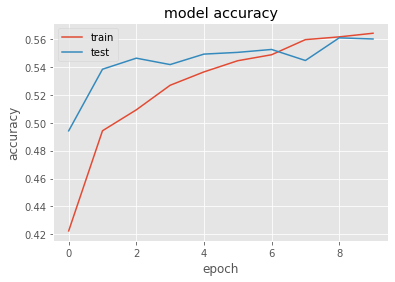

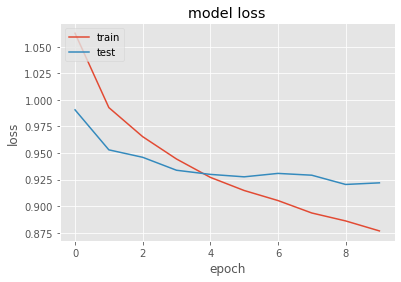

In [ ]:
# model accuracy and loss graphs
import matplotlib.pyplot as plt

plt.plot(modHistory.history['accuracy'])
plt.plot(modHistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #plotting the accuracy  vs the number of epochs

plt.plot(modHistory.history['loss'])
plt.plot(modHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #plotting the loss vs the number of epochs